# CycleGAN Abstract Forests

Here, I used a CycleGAN to generate abstract pictures of forests. For the CycleGAN, I used the PyTorch implementation from the creators of the CycleGAN. Their library can be found [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

## Importing functions

In [5]:
from pathlib import Path
import sys
import os

cwd = os.getcwd()

sys.path.append(str(Path(cwd+"/fastai/old")))
sys.path.append(str(Path(cwd+"/cgan")))
sys.path.append(str(Path(cwd+"/cgan/data")))

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *
from cgan.options.train_options import *
from sklearn.model_selection import train_test_split
from cgan.options.train_options import TrainOptions
from cgan.data.data_loader import CreateDataLoader
from cgan.models.models import create_model
from cgan.util.visualizer import Visualizer
from google_images_download import google_images_download

In [7]:
# hide EXIF warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

## Selecting images for training

For training, I used images of "famous abstract paintings" and "forests" These images were scraped from Google Images. After scraping 400 images, I went through and chose 216 images from each category. These were the images included in training.<br>

First **download** images for training

In [ ]:
#class instantiation
response = google_images_download.googleimagesdownload()   

#creating list of arguments
arguments = {"keywords":"portraits",
             "limit":400,
             "output_directory":Path(cwd+"/input_data/"),
             "chromedriver":Path(cwd+"/chromedriver")}

#passing the arguments to the function
paths = response.download(arguments)   

## Constructing the model

Now constructing the CycleGAN Model. Specifying options. If you go to the CycleGAN library linked above, you can see what each of the specifications mean and other options. <br>

If you want to continue training where you left off use **--continue_train: True** and **--epoch_count:**

In [8]:
opt = TrainOptions().parse(['--dataroot', 'input_data/', 
                            '--nThreads', '4', 
                            '--name', 'polygon_mountains',
                            '--no_dropout',
                            '--save_epoch_freq', '1',
                            '--loadSize', '440',
                            '--fineSize', '400',
                            '--display_winsize', '400',
                            '--niter', '100',
                            '--niter_decay', '100',
                            '--gpu_ids', '0'])

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: input_data/
dataset_mode: unaligned
display_freq: 100
display_id: 1
display_port: 8097
display_single_pane_ncols: 0
display_winsize: 400
epoch_count: 1
fineSize: 400
gpu_ids: [0]
init_type: normal
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
lambda_identity: 0.5
loadSize: 440
lr: 0.0002
lr_decay_iters: 50
lr_policy: lambda
max_dataset_size: inf
model: cycle_gan
nThreads: 4
n_layers_D: 3
name: polygon_mountains
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_dropout: True
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
resize_or_crop: resize_and_crop
save_epoch_freq: 1
save_latest_freq: 5000
serial_batches: False
update_html_freq: 1000
which_direction: AtoB
which_epoch: latest
which_model_netD: basic
which_model_netG: resnet_9blocks
-------------- End ----------------


Now creating the dataset. Just to note it automatically is looking for directories *trainA* and *trainB*. These directories should contain your images. You also have the option of including test images, which should be in directories *testA* and *testB*. Note, I do not have any images here in the test set, since the goal is to create art and not necessarily a model that generalizes.

In [9]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print ('Size of dataset:', dataset_size)

CustomDatasetDataLoader
dataset [UnalignedDataset] was created
Size of dataset: 252


Below creating the model and also the visualizer, which allows you to visualize the images during training in visdom. It is allows you to save the example training images in a html page.

In [10]:
model = create_model(opt)

cycle_gan
initialization method [normal]
initialization method [normal]
initialization method [normal]
initialization method [normal]
---------- Networks initialized -------------
ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
        (3): ReLU(inpla

## Training  the model

Finally ready to train the model. The code below is pretty much taken from the CycleGAN library, so nothing special there. Just run the cell below and training will start.

In [10]:
total_steps = 0

print ("---- starting to train '%s' ----" % (opt.name))

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in tqdm(enumerate(dataset)):
        iter_start_time = time.time()
        if total_steps % opt.print_freq == 0: t_data = iter_start_time - iter_data_time
        total_steps += opt.batchSize
        epoch_iter += opt.batchSize
        model.set_input(data)
        model.optimize_parameters()
        
        if total_steps % opt.print_freq == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batchSize

        iter_data_time = time.time()
        
    if epoch % opt.save_epoch_freq == 0:
        save_name = str(epoch)+'_'+opt.name
        model.save(save_name)
        model.save('latest')

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

---- starting to train 'polygon_mountains' ----
19it [00:40,  2.14s/it]
0it [00:00, ?it/s]

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f995f69ff60>>
Traceback (most recent call last):
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/henrik/anaconda3/envs/fastai/

19it [00:15,  1.24it/s]

Process Process-9:
Process Process-11:
Process Process-10:
Traceback (most recent call last):
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loo

KeyboardInterrupt: 

  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


19it [00:15,  1.22it/s]

  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/henrik/anaconda3/envs/fastai/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


## Visualizing the results

Now finially ready to visualize the results.
I am loading the pretrained model so I just set *--epoch_count* to *200* and *--which_epoch* to the name of the saved weight and *--name* to the model name

**Skip if model already is created**

In [ ]:
# if you want to make any changes to the parameters and create a new model
opt = TrainOptions().parse(['--dataroot', 'data/input_data/', 
                            '--nThreads', '4', 
                            '--no_dropout',
                            '--niter', '100', 
                            '--niter_decay', '100', 
                            '--name', 'polygon_mountains', 
                            '--gpu_ids', '0',
                            '--continue_train',
                            '--epoch_count', '200', 
                            '--which_epoch', '200_nodrop'])
model = create_model(opt)

If model already exist you can simply change the parameters

In [11]:
# easy way to specify which_epoc etc
model.opt.isTrain=False
model.opt.which_epoch='latest'

In [12]:
# Function to show images
def show_img(im, ax=None, figsize=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# Function to generate one image. Funciton called two cells below
def get_one(data):
    model.set_input(data)
    model.test()
    return list(model.get_current_visuals().values())

In [13]:
# Creating list of generated forest images
generated_img = []
for i,o in tqdm(enumerate(dataset)):
    try:
        vis = get_one(o)
        generated_img.append(vis)
    except:
        pass

252it [00:34,  7.26it/s]


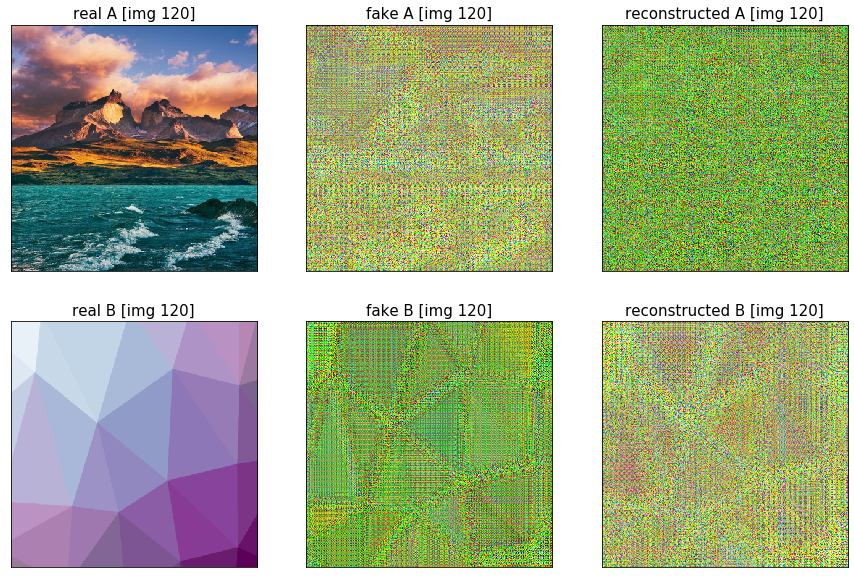

In [14]:
descriptor = ['real A', 'fake A', 'reconstructed A', 'real B', 'fake B', 'reconstructed B']

rand_int = random.randrange(dataset_size)
fig,axes = plt.subplots(2,3,figsize=(15,10))
for i, ax in enumerate(axes.flat): 
    show_img(generated_img[rand_int][i],ax)
    title = '%s [img %d]' % (descriptor[i], rand_int)
    ax.set_title(title,fontsize=15)

In [ ]:
# Visualize some of the generated images
fig,axes = plt.subplots(2,5,figsize=(15,7))
for i, ax in enumerate(axes.flat):
    try:
        count += 1
    except NameError:
        count = 0
    show_img(generated_img[count][1],ax)
    ax.set_title(count,fontsize=15)

Save the generated images to specified folder

In [ ]:
# Path of where to save images
OUT_PATH = Path(cwd+"/generated_images/"+opt.name)

for i in range(len(generated_img)):
    plt.imsave((OUT_PATH/f'{i}.png'),generated_img[i][1])
fig.tight_layout()